In [1]:
import os
import sys
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

## 1. Get statistics of partitioning

In [2]:
path = "../data/matrix_city/aerial/train/block_all/data_partitions"
files = [f for f in os.listdir(path) if f.endswith('.npy')]
print(files)

['block_mc_aerial_block_all_lr_c36_loss_5.npy', 'block_mc_aerial_block_all_lr_c36_loss_8.npy', 'block_mc_aerial_block_all_lr_c36_loss_12.npy', 'block_mc_aerial_block_all_lr_c36_loss_8_num_5w.npy', 'block_mc_aerial_block_all_lr_c36_loss_8_num_10w.npy', 'block_mc_aerial_block_all_lr_c36_loss_8_num_20w.npy', 'block_mc_aerial_block_all_lr_c25_loss_8_num_10w_lr2.npy', 'block_mc_aerial_block_all_lr_c36_loss_5_simple_selection.npy', 'block_mc_aerial_block_all_lr_c36_loss_100.npy', 'block_mc_aerial_block_all_lr_c36_loss_5_dis_inblock.npy']


In [3]:
distributions = []
for f in files:
    partition = np.load(os.path.join(path, f))
    distribution = partition.sum(axis=0)
    mean = int(distribution.mean())
    std = int(distribution.std())
    distributions.append(partition.sum(axis=0))
    print(f, mean, std)

block_mc_aerial_block_all_lr_c36_loss_5.npy 440 214
block_mc_aerial_block_all_lr_c36_loss_8.npy 352 198
block_mc_aerial_block_all_lr_c36_loss_12.npy 295 172
block_mc_aerial_block_all_lr_c36_loss_8_num_5w.npy 358 189
block_mc_aerial_block_all_lr_c36_loss_8_num_10w.npy 378 161
block_mc_aerial_block_all_lr_c36_loss_8_num_20w.npy 417 115
block_mc_aerial_block_all_lr_c25_loss_8_num_10w_lr2.npy 483 186
block_mc_aerial_block_all_lr_c36_loss_5_simple_selection.npy 371 173
block_mc_aerial_block_all_lr_c36_loss_100.npy 156 83
block_mc_aerial_block_all_lr_c36_loss_5_dis_inblock.npy 355 196


## 2. Analyze particular block

In [4]:
sys.path.append('/home/yang_liu/python_workspace/3DGS')
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
import yaml
from tqdm import tqdm
from scene import LargeScene, GaussianModel
from scene.datasets import GSDataset
from utils.loss_utils import l1_loss, ssim
from train_large import parse_cfg
from gaussian_renderer import render_v2

In [46]:
block_id = 16
config_name = "block_mc_street_block_all_lr_c36_simple_selection_lr2"
config = f'../config/{config_name}.yaml'
with open(config) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    lp, op, pp = parse_cfg(cfg)
    lp.source_path = os.path.join("../", lp.source_path)
    lp.pretrain_path = os.path.join("../", lp.pretrain_path)
    lp.model_path = os.path.join("../output/", config_name)
    setattr(lp, 'config_path', config)
    setattr(lp, 'block_id', block_id)
    # setattr(lp, 'pretrain_path', f"../output/{config_name}/cells/cell{block_id}/point_cloud/iteration_30000")

gaussians = GaussianModel(lp.sh_degree)
scene = LargeScene(lp, gaussians)
gs_dataset = GSDataset(scene.getTrainCameras(), scene, lp, pp)

Using Partition File block_mc_street_block_all_lr_c36_simple_selection.npy
Reading camera 4075/4075
Filtered Cameras: 575. 


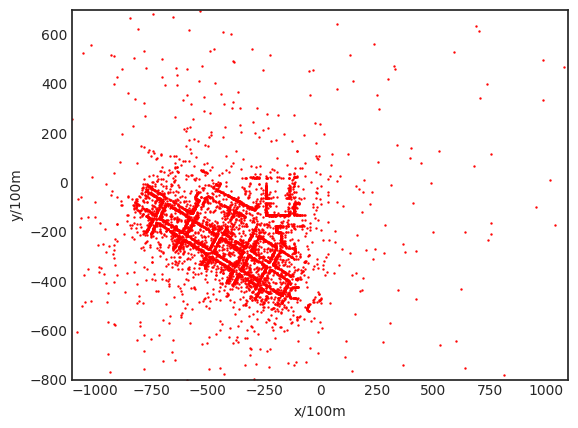

In [6]:
xyz_org = gaussians.get_xyz
plt.style.use('seaborn-white')
plt.figure()
plt.scatter(xyz_org[::200, 0].detach().cpu(), xyz_org[::200, 1].detach().cpu(), s=0.5, c='r')
plt.xlim(-1100, 1100)
plt.ylim(-800, 700)
plt.xlabel('x/100m')
plt.ylabel('y/100m')
plt.legend()
# plt.grid(True)
plt.show()

In [47]:
views = scene.getTrainCameras()
bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

In [48]:
ssim_losses = []
l1_losses = []

# idx = 64
with torch.no_grad():
    for idx in tqdm(range(len(gs_dataset))):
        cam_info, gt_image = gs_dataset[idx]
        image_name = os.path.split(gs_dataset.cameras[idx].image_path)[1]
        render_pkg = render_v2(cam_info, gaussians, pp, background)
        image = render_pkg["render"].cpu().numpy().transpose(1,2,0)
        ssim_loss = 1.0 - ssim(render_pkg["render"], gt_image)
        l1 = l1_loss(render_pkg["render"], gt_image)

        ssim_losses.append(ssim_loss)
        l1_losses.append(l1)

  0%|          | 0/575 [00:00<?, ?it/s]

100%|██████████| 575/575 [01:13<00:00,  7.87it/s]


Text(0, 0.5, 'Weights')

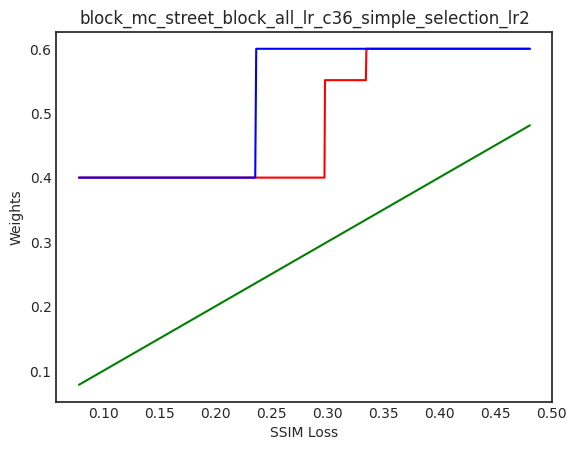

In [59]:
samples_weight = torch.tensor(ssim_losses)
samples_weight, _ = torch.sort(samples_weight)

num_bins = samples_weight.shape[0] // 50
hist, bin_edges = torch.histogram(samples_weight, bins=num_bins, density=True)
hist = torch.cumsum(hist / hist.sum(), dim=0)
hist = torch.clamp(hist, 0.4, 0.6)
weights_cumsum = torch.zeros_like(samples_weight)
for i in range(num_bins):
    weights_cumsum[(samples_weight >= bin_edges[i]) & (samples_weight <= bin_edges[i+1])] = hist[i]

weights_unit = torch.zeros_like(samples_weight)
mask = samples_weight >= samples_weight.mean() - samples_weight.std()
weights_unit[mask] = 0.6
weights_unit[~mask] = 0.4
plt.title(config_name)
plt.plot(samples_weight.cpu().numpy(), weights_cumsum.cpu().numpy(), c='r')
plt.plot(samples_weight.cpu().numpy(), samples_weight.cpu().numpy(), c='g')
plt.plot(samples_weight.cpu().numpy(), weights_unit.cpu().numpy(), c='b')
plt.xlabel('SSIM Loss')
plt.ylabel('Weights')

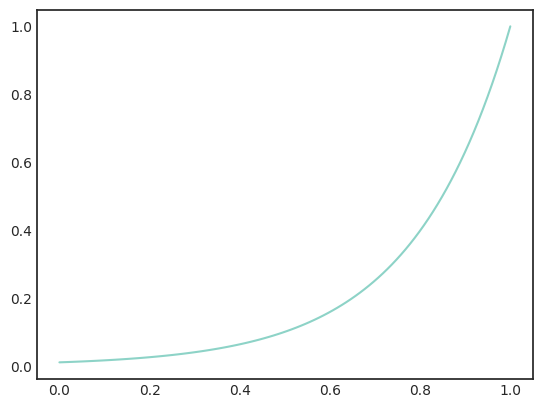

In [71]:
t = np.linspace(0, 1, 100)
lr_init = 1e-2
lr_final = 1.0
log_lerp = np.exp(np.log(lr_init) * (1 - t) + np.log(lr_final) * t)
plt.plot(t, log_lerp)

Text(0.5, 1.0, 'L1 Loss, mean: 0.0544, std: 0.0135')

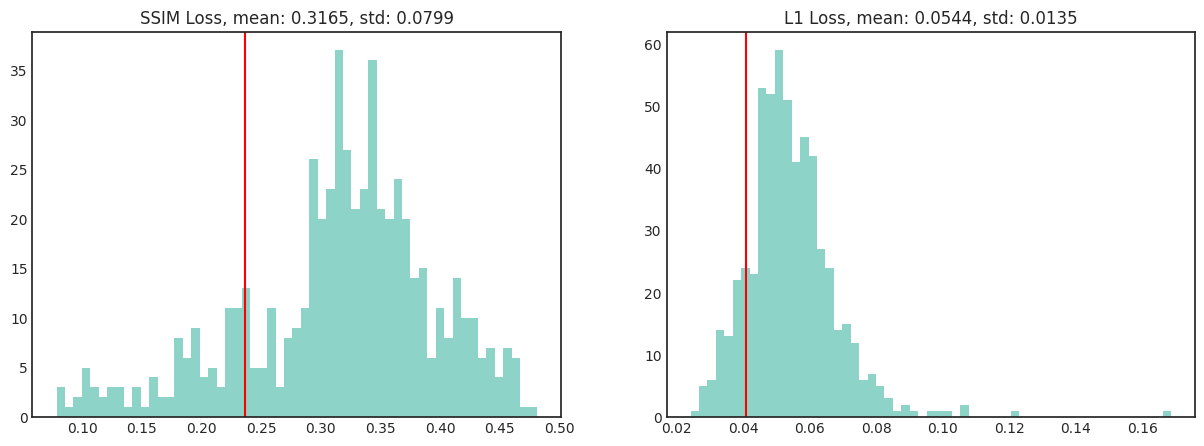

In [50]:
plt.style.use('seaborn-white')
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
ssims_list = [x.cpu().numpy().squeeze() for x in ssim_losses]
ssim_std = np.std(ssims_list)
ssim_mean = np.mean(ssims_list)
ssim_theshold = ssim_mean - ssim_std
# plt.plot(ssims_list)
# plt.axhline(y=ssim_mean, color='r', linestyle='-')
plt.hist(ssims_list, bins=len(ssims_list)//10)
plt.axvline(x=ssim_theshold, color='r', linestyle='-')
plt.title(f"SSIM Loss, mean: {ssim_mean:.4f}, std: {ssim_std:.4f}")

plt.subplot(1, 2, 2)
l1_list = [x.cpu().numpy().squeeze() for x in l1_losses]
l1_std = np.std(l1_list)
l1_mean = np.mean(l1_list)
l1_theshold = l1_mean - l1_std
# plt.plot(l1_list)
# plt.axhline(y=l1_mean, color='r', linestyle='-')
plt.hist(l1_list, bins=len(l1_list)//10)
plt.axvline(x=l1_theshold, color='r', linestyle='-')    
plt.title(f"L1 Loss, mean: {l1_mean:.4f}, std: {l1_std:.4f}")

In [11]:
ssim_mask = np.array(ssims_list) > ssim_theshold
l1_mask = np.array(l1_list) > l1_theshold
print(f"SSIM Loss > {ssim_theshold}: {np.sum(ssim_mask)} images")
print(f"L1 Loss > {l1_theshold}: {np.sum(l1_mask)} images")

SSIM Loss > 0.18469299376010895: 299 images
L1 Loss > 0.037233784794807434: 295 images


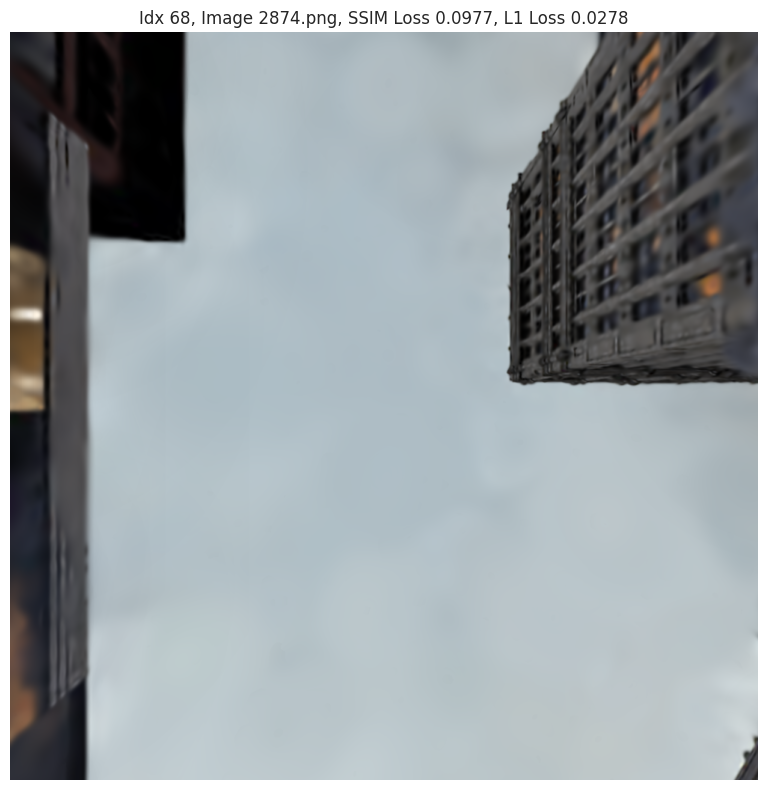

In [12]:
# idx = random.choice(np.where(ssim_mask)[0])
idx = random.randint(0, len(gs_dataset))
# for idx, cam in enumerate(gs_dataset.cameras):
#     if cam.image_name == '2791':
#         break
with torch.no_grad():
    cam_info, gt_image = gs_dataset[idx]
    image_name = os.path.split(gs_dataset.cameras[idx].image_path)[1]
    render_pkg = render_v2(cam_info, gaussians, pp, background)
    image = render_pkg["render"].cpu().numpy().transpose(1,2,0)
    ssim_loss = 1.0 - ssim(render_pkg["render"], gt_image)
    l1 = l1_loss(render_pkg["render"], gt_image)
    diff_image = torch.abs((render_pkg["render"] - gt_image))


plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.title(f"Idx {idx}, Image {image_name}, SSIM Loss {ssim_loss:.4f}, L1 Loss {l1:.4f}")
plt.axis('off')
plt.tight_layout()
plt.show()

# plt.figure(figsize=(8, 8))
# plt.imshow(diff_image.cpu().numpy().transpose(1,2,0))
# plt.axis('off')
# plt.tight_layout()
# plt.show()